# MLP 

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

import requests 
from tqdm import tqdm

In [2]:
with open( "names.txt") as f:
    words = (f.read().lower()).split()

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set((''.join(words)))))  #get unique characters 
stoi = {s:i+1 for i, s in enumerate(chars)}  # map char to int
stoi["."] = 0 
itos = {i:s for s, i in stoi.items()}        # map int to char

In [13]:
# build the dataset
block_size = 10 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182437, 10]) torch.Size([182437])
torch.Size([22781, 10]) torch.Size([22781])
torch.Size([22928, 10]) torch.Size([22928])


In [15]:
n_dim = 4

C = torch.randn((27, n_dim)) 
W1 = torch.randn((n_dim * block_size, 200)) / ((5/3) / (n_dim * block_size)**0.5)
b1 = torch.randn(200 ) * 0.0
W2 = torch.randn((200, 27) ) /((200)**0.5)
b2 = torch.randn(27) * 0.0
parameters = [C, W1, b1, W2, b2]


In [16]:
sum(p.nelement() for p in parameters) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [17]:
stepi = []; lossi=[]

In [22]:
its = 1000
for i in tqdm(range(its)):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (512,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, n_dim*block_size) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = torch.linspace(0.1, 0.05, its)
  for p in parameters:
    p.data += -lr[i] * p.grad

  # track stats
  #lri.append(lre[i])
  if i%100 ==0:print(loss.item())
  stepi.append(i)
  lossi.append(loss.log10().item())
   


 18%|█▊        | 177/1000 [00:00<00:00, 892.54it/s]

2.3697593212127686
2.387899398803711


 35%|███▌      | 354/1000 [00:00<00:00, 861.71it/s]

2.348072052001953
2.4331159591674805


 53%|█████▎    | 526/1000 [00:00<00:00, 829.15it/s]

2.3483870029449463
2.3465447425842285


 68%|██████▊   | 683/1000 [00:00<00:00, 607.51it/s]

2.3529932498931885


 82%|████████▏ | 815/1000 [00:01<00:00, 601.19it/s]

2.3780357837677
2.4751391410827637


100%|██████████| 1000/1000 [00:01<00:00, 667.38it/s]

2.3836915493011475


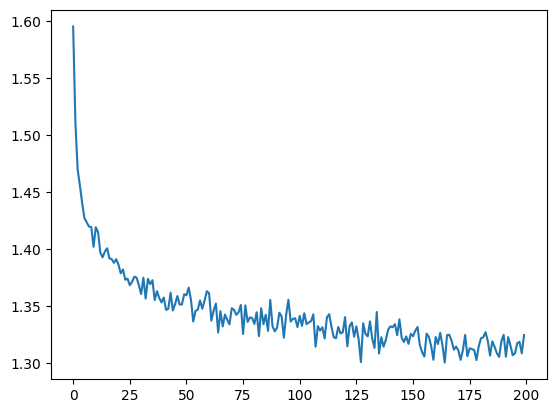

In [23]:
plt.plot( torch.tensor(lossi).view(-1,10).sum(axis=1).log().numpy())

In [24]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]

    emb=C[x]
    emcat = emb.view(emb.shape[0],-1)
    h = torch.tanh(emcat@ W1 + b1)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, y)
    print(split,loss.item())

split_loss('train')
split_loss('val')
# split_loss('test')

train 2.3535337448120117
val 2.374828577041626


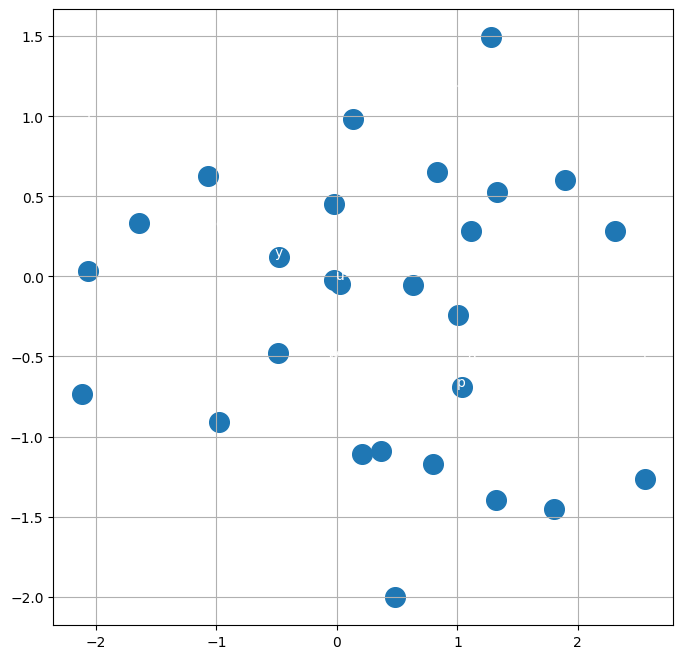

In [25]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,2].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [27]:
# sample from the model
# g = torch.Generator().manual_seed(2147483647 + 89)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

miryntseigongoq.
sajhah.
saame.
niclea.
sertr.
sqmahleh.
zagit.
siahnaian.
jpalle.
evevinn.
friefiwa.
xxyha.
malae.
malaiel.
ujoaye.
rasira.
ayrher.
ezlie.
khayi.
shamed.
